# Flow peakiness exploration

The latest results indicate that peakiness did not change for flow, only for occupancy. This could be due to nonlinearities, but could also be due to a bug. Investigate by finding some representative days where this happened and actually looking at the changes.

In [1]:
using Plots, KFactors, DataFrames, StatsBase, CSV, RollingFunctions, Dates, Measures
using Pipe: @pipe

In [2]:
data = read_data("../data/peaks_merged.parquet");

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.89%)
└ @ KFactors /Users/mwbc/git/peak-spreading/src/computation.jl:67


## Find sensors that have opposite changes in occupancy peakiness and flow peakiness pre-post

In [9]:
data = KFactors.create_test_data(data, KFactors.Periods.SPRING_2022)

,station,peak_hour_occ,peak_hour_occ_avg,peak_hour_flow,peak_hour_demand,peak_hour_demand_avg
,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,312010,0.134762,0.364158,0.0351875,0.0765258,9368.93
2,312098,0.0936754,0.188375,0.0565509,0.0631433,9490.0
3,312103,0.113312,0.272917,0.0636459,0.0824705,9321.14
4,312132,0.0778201,0.0816333,0.0859421,0.088392,2273.0
5,312134,0.0742908,0.0820833,0.0736952,0.0736952,2550.0
6,312139,0.105445,0.348317,0.0552882,0.0919537,15794.6
7,312326,0.0875532,0.0480083,0.0966536,0.0966536,2715.0
8,312346,0.079661,0.10245,0.0741977,0.0754064,4991.0
9,312386,0.167777,0.2618,0.061312,0.0849627,5647.73


In [10]:
sensor_change = @pipe groupby(data, [:station, :period]) |>
    combine(_, :peak_hour_occ => mean, :peak_hour_flow => mean, :total_flow => mean, :occ_entropy => mean);

In [14]:
occ = unstack(sensor_change, :station, :period, :peak_hour_occ_mean)
rename!(occ, Dict(:prepandemic=>:prepandemic_occ, :lockdown=>:lockdown_occ, :postlockdown=>:postlockdown_occ))
flow = unstack(sensor_change, :station, :period, :peak_hour_flow_mean)
rename!(flow, Dict(:prepandemic=>:prepandemic_flow, :lockdown=>:lockdown_flow, :postlockdown=>:postlockdown_flow))
tot_flow = unstack(sensor_change, :station, :period, :total_flow_mean)
rename!(tot_flow, Dict(:prepandemic=>:prepandemic_tot_flow, :lockdown=>:lockdown_tot_flow, :postlockdown=>:postlockdown_tot_flow))
entr = unstack(sensor_change, :station, :period, :occ_entropy_mean)
rename!(entr, Dict(:prepandemic=>:prepandemic_entropy, :lockdown=>:lockdown_entropy, :postlockdown=>:postlockdown_entropy))

sensor_change = @pipe leftjoin(occ, flow, on=:station) |> leftjoin(_, tot_flow, on=:station) |> leftjoin(_, entr, on=:station)


,station,prepandemic_occ,lockdown_occ,postlockdown_occ,prepandemic_flow,lockdown_flow
,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,312010,0.122021,0.0961923,0.0961329,0.0533563,0.0649146
2,312098,0.13752,0.137754,0.0867117,0.054225,0.0656908
3,312103,0.115716,0.0910452,0.08299,0.0542523,0.0681638
4,312132,0.074646,0.0961218,0.0567051,0.0788333,0.0884172
5,312134,0.0981855,0.0755514,0.0630392,0.0701147,0.0684454
6,312139,0.103666,0.101803,0.10487,0.0513595,0.0605412
7,312326,0.0895404,0.0720224,0.0842464,0.0788062,0.0677511
8,312346,0.0820492,0.0743522,0.0822047,0.074387,0.06963
9,312386,0.157485,0.0826299,0.0693108,0.0532759,0.0631552


In [16]:
# occ got less peaky, flow got more
ch = sensor_change[
    coalesce.(((sensor_change.postlockdown_occ - sensor_change.prepandemic_occ) .< 0.01) .& ((sensor_change.postlockdown_flow - sensor_change.prepandemic_flow) .> 0.01), false),
    [:station, :prepandemic_occ, :postlockdown_occ, :prepandemic_flow, :postlockdown_flow]]

,station,prepandemic_occ,postlockdown_occ,prepandemic_flow,postlockdown_flow
,Int64?,Float64?,Float64?,Float64?,Float64?
1,312098,0.13752,0.0867117,0.054225,0.0696487
2,312386,0.157485,0.0693108,0.0532759,0.0676788
3,312689,0.155449,0.130221,0.048568,0.0587673
4,312858,0.115769,0.0745262,0.0508329,0.0613077
5,313166,0.121091,0.0778467,0.0557199,0.0674727
6,313438,0.109667,0.0805598,0.0634979,0.0752314
7,313444,0.0926776,0.0836816,0.062637,0.0763237
8,316018,0.0923032,0.0854077,0.0709156,0.082776
9,317910,0.126442,0.112668,0.0464069,0.0588125


## Make the plots

In [17]:
occflow = CSV.read("../data/flow_occ_distr.csv", DataFrame)

,station,period,time,flow,occ,flow_obs,occ_obs
,Int64,String15,Time,Float64,Float64,Int64,Int64
1,817125,prepandemic,00:00:00,64.2308,0.0247792,130,130
2,817125,prepandemic,00:01:00,64.8923,0.0248769,130,130
3,817125,prepandemic,00:02:00,65.8923,0.0251115,130,130
4,817125,prepandemic,00:03:00,64.6462,0.0250392,130,130
5,817125,prepandemic,00:04:00,60.8769,0.0234577,130,130
6,817125,prepandemic,00:05:00,56.2538,0.0224692,130,130
7,817125,prepandemic,00:06:00,55.2692,0.0223754,130,130
8,817125,prepandemic,00:07:00,51.8462,0.0212938,130,130
9,817125,prepandemic,00:08:00,51.7846,0.0210908,130,130


In [48]:
# fix error in data creation
occflow.time = Dates.Time.(Dates.hour.(occflow.time), Dates.minute.(occflow.time) * 5)

16070400-element Vector{Time}:
 00:00:00
 00:05:00
 00:10:00
 00:15:00
 00:20:00
 00:25:00
 00:30:00
 00:35:00
 00:40:00
 00:45:00
 00:50:00
 00:55:00
 01:00:00
 ⋮
 23:00:00
 23:05:00
 23:10:00
 23:15:00
 23:20:00
 23:25:00
 23:30:00
 23:35:00
 23:40:00
 23:45:00
 23:50:00
 23:55:00

In [18]:
meta = CSV.read("../data/sensor_meta_geo.csv", DataFrame)

,ID,fwy_stable,dir_stable,lanes_stable,max_shift_meters,Latitude,Longitude
,Int64,Bool,Bool,Bool,Float64,Float64,Float64
1,311831,1,1,1,59.5162,38.4098,-121.484
2,311844,1,1,1,80.6189,38.4128,-121.484
3,311845,1,1,1,0.0,38.4062,-121.483
4,311847,1,1,1,91.9547,38.4283,-121.488
5,312010,1,1,1,9.62967,38.5638,-121.493
6,312098,1,1,1,85.7125,38.559,-121.476
7,312103,1,1,1,12.8604,38.561,-121.463
8,312132,1,1,1,9.56544,38.4098,-121.484
9,312133,1,1,1,53.2263,38.4282,-121.488


In [19]:
occflow = leftjoin(occflow, meta, on=:station=>:ID)

,station,period,time,flow,occ,flow_obs,occ_obs,fwy_stable
,Int64,String15,Time,Float64,Float64,Int64,Int64,Bool?
1,817125,prepandemic,00:00:00,64.2308,0.0247792,130,130,1
2,817125,prepandemic,00:01:00,64.8923,0.0248769,130,130,1
3,817125,prepandemic,00:02:00,65.8923,0.0251115,130,130,1
4,817125,prepandemic,00:03:00,64.6462,0.0250392,130,130,1
5,817125,prepandemic,00:04:00,60.8769,0.0234577,130,130,1
6,817125,prepandemic,00:05:00,56.2538,0.0224692,130,130,1
7,817125,prepandemic,00:06:00,55.2692,0.0223754,130,130,1
8,817125,prepandemic,00:07:00,51.8462,0.0212938,130,130,1
9,817125,prepandemic,00:08:00,51.7846,0.0210908,130,130,1


In [20]:
occflow[occflow.station .== 400010,:]

,station,period,time,flow,occ,flow_obs,occ_obs,fwy_stable
,Int64,String15,Time,Float64,Float64,Int64,Int64,Bool?
1,400010,prepandemic,00:00:00,103.563,0.0194874,174,174,1
2,400010,prepandemic,00:01:00,103.557,0.019531,174,174,1
3,400010,prepandemic,00:02:00,102.092,0.0192454,174,174,1
4,400010,prepandemic,00:03:00,94.0862,0.0176943,174,174,1
5,400010,prepandemic,00:04:00,88.5977,0.0169782,174,174,1
6,400010,prepandemic,00:05:00,87.2126,0.0166379,174,174,1
7,400010,prepandemic,00:06:00,84.8161,0.0162075,174,174,1
8,400010,prepandemic,00:07:00,84.6667,0.0161063,174,174,1
9,400010,prepandemic,00:08:00,79.092,0.0151489,174,174,1


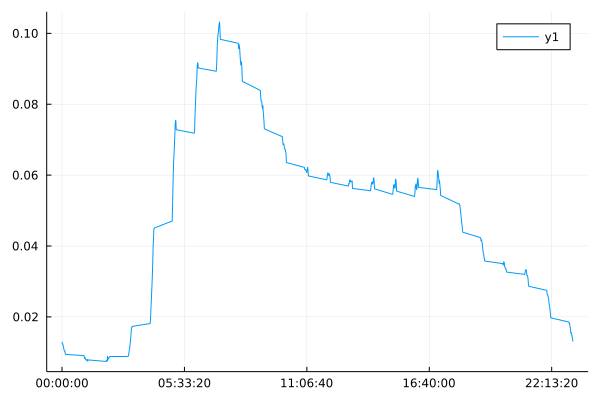

In [45]:
plot(occflow[occflow.station .== 400010 .&& occflow.period .== "postlockdown", :time], occflow[occflow.station .== 400010 .&& occflow.period .== "postlockdown", :occ])

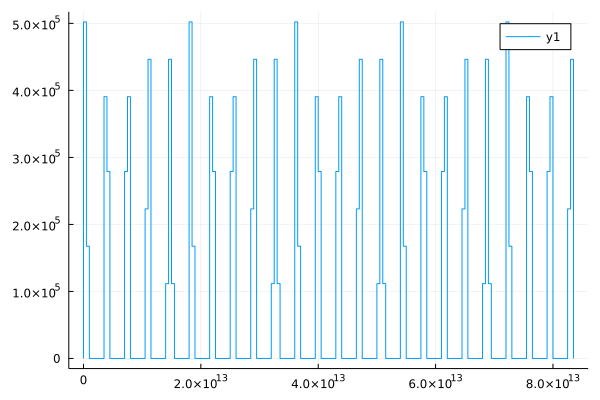

In [47]:
histogram(occflow.time)

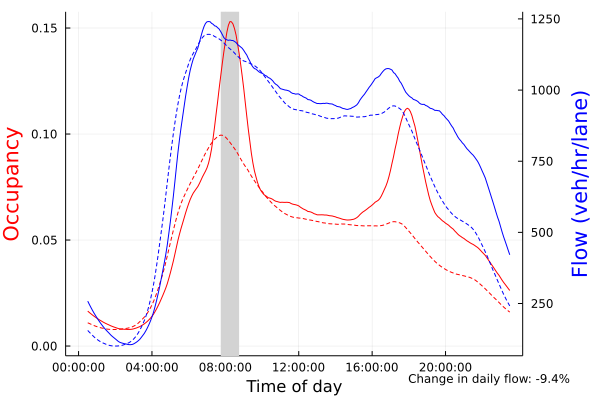

In [72]:
function plotst(st; legend=false, xlabel=nothing, occupancy=true, flow=true, normalize=false)
    stdata = occflow[occflow.station .== st, :]
    pre = stdata[stdata.period .== "prepandemic", [:time, :flow, :occ, :flow_obs, :Lanes]]
    sort!(pre, :time)    
    post = stdata[stdata.period .== "postlockdown", [:time, :flow, :occ, :flow_obs, :Lanes]]
    sort!(post, :time)
    
    pre_occ = rollmean(pre.occ, 12)
    post_occ = rollmean(post.occ, 12)
    pre_flow = rollmean(pre.flow, 12)
    post_flow = rollmean(post.flow, 12)
    # The first element of pre_occ etc is the mean from 0:00 to 1:00 - so we want that displayed at 0:30
    x = pre.time[7:(length(pre_occ) + 6)]
    
    if normalize
        pre_occ ./= sum(pre_occ)
        post_occ ./= sum(post_occ)
        pre_flow ./= sum(pre_flow)
        post_flow ./= sum(post_flow)
    end
    
    peakhr = x[argmax(pre_occ)] - Dates.Minute(30)
    vspan([peakhr, peakhr + Dates.Hour(1)], color="lightgray", label="Pre-pandemic peak hour")

    if occupancy
        plot!(x, pre_occ, label="Occupancy, pre", color="red", legend=legend,
            xticks=Dates.Time(0, 0, 0):Dates.Hour(4):Dates.Time(23, 0, 0), right_margin=50pt)
        plot!(x, post_occ, label="Occupancy, post", color="red", linestyle=:dash)
    end
    plot!([0], [0], label="Flow, pre", color="blue")
    plot!([0], [0], label="Flow, post", color="blue", linestyle=:dash)
    flowch = round((sum(post.flow) / sum(pre.flow) - 1) * 100; digits=1)
    xlabel!("Time of day")
    
    annotate!((Dates.Time(18), -0.1 * max(maximum(pre_occ), maximum(post_occ)), text("Change in daily flow: $(flowch > 0 ? '+' : '-')$(abs(flowch))%", pointsize=8, halign=:left)))
    
    ylabel!("Occupancy")
    plot!(yguidefont=font(:red))
    
    if flow
        ax2 = twinx()
        plot!(ax2, x, pre_flow .* 12 ./ pre.Lanes[1], color="blue", legend=false, xticks=[])
        plot!(ax2, x, post_flow .* 12 ./ pre.Lanes[1], color="blue", linestyle=:dash)
        ylabel!(ax2, "Flow (veh/hr/lane)")
        plot!(ax2, yguidefont=font(:blue))
    end
end

# This one is concerning and does look like maybe caused by decreased flow
plotst(400010)

In [100]:
sensor_change[abs.(sensor_change.postlockdown_tot_flow ./ sensor_change.prepandemic_tot_flow .- 1) .< 0.05 .&& sensor_change.prepandemic_tot_flow .> 80000, :station][550:800]

251-element Vector{Union{Missing, Int64}}:
  773330
  773362
  773422
  773458
  773490
  773492
  773535
  773723
  773743
  773773
  773795
  773796
  773996
       ⋮
 1202230
 1202475
 1202742
 1202753
 1202779
 1202785
 1202827
 1202844
 1202855
 1203110
 1203124
 1203136

In [91]:
sum(occflow[occflow.station .== 770076 .&& occflow.period .== "prepandemic", :flow])

65783.77214138594

In [80]:
sensor_change[sensor_change.station .== 761644, [:prepandemic_tot_flow, :postlockdown_tot_flow]]

,prepandemic_tot_flow,postlockdown_tot_flow
,Float64?,Float64?
1,82017.8,24501.0


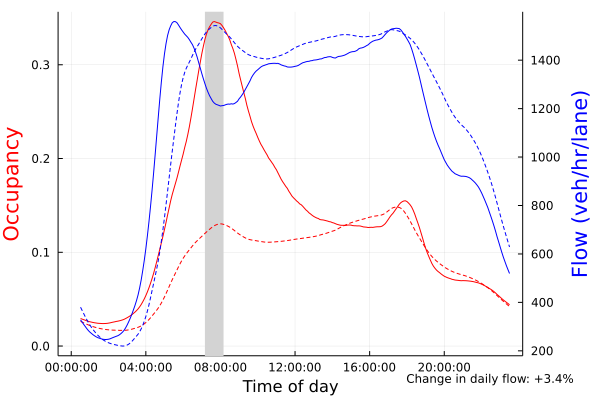

In [109]:
# this is what I expect - flow suppressed by occupancy
plotst(773458)

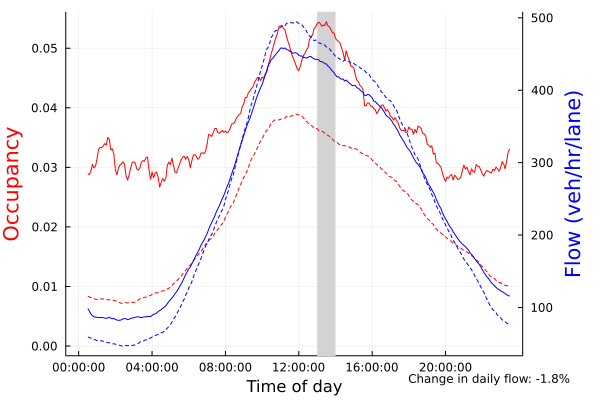

In [17]:
plotst(317789)

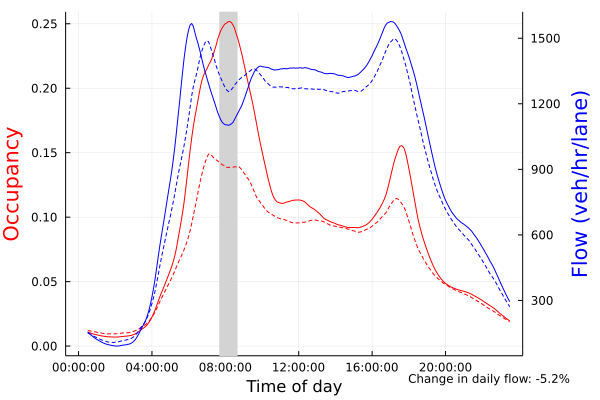

In [18]:
plotst(1215809)

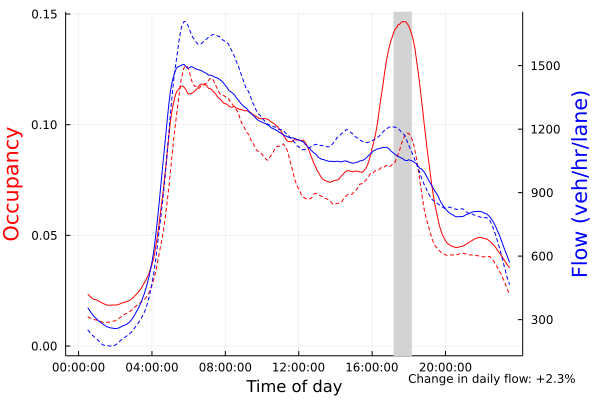

In [19]:
plotst(404895)

## Paper figure

To explain this in the paper, let's make a figure that shows how occ and flow don't always track.

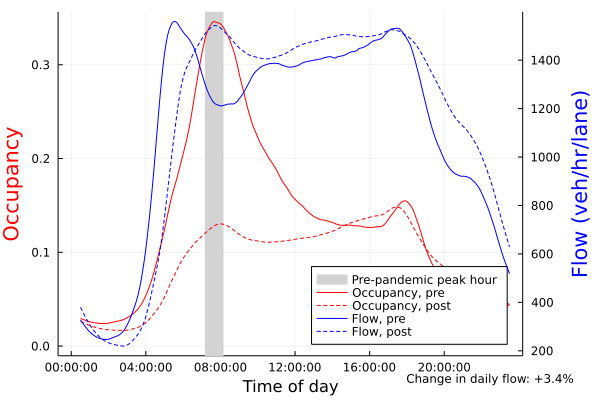

In [110]:
# this is a good example of how this can happen. Flow during the peak was suppressed before,
# and less so now due to peak spreading.
plotst(773458, legend=:bottomright, xlabel="Time of day")
savefig("../fig/occ_and_flow.pdf")
plot!()

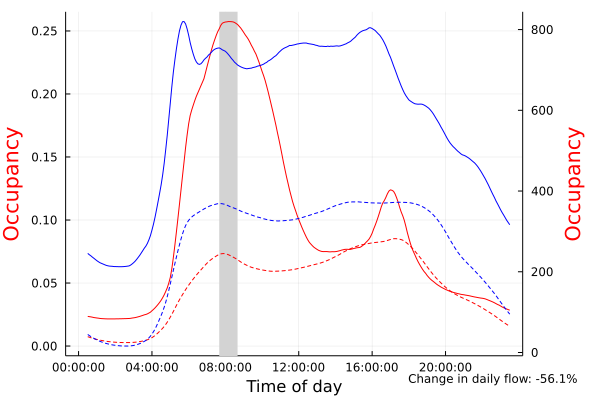

In [55]:
groupby(data, [:station, :period])

In [21]:
sensor_change[sensor_change.station .== 716941, [:prepandemic_occ, :prepandemic_flow, :postpandemic_occ, :postpandemic_flow]]

,prepandemic_occ,prepandemic_flow,postpandemic_occ,postpandemic_flow
,Float64?,Float64?,Float64?,Float64?
1,0.110823,0.037846,0.0696074,0.0564535


## Opposite changes in k-factor and entropy

Sam found that only 51.1% of sensors indicated less peaky occupancy and occentropy. Find some of these sensors and evaluate.

In [57]:
sensor_change[coalesce.(sensor_change.postpandemic_entropy .- sensor_change.prepandemic_entropy .< 0, false) .&&
    coalesce.(sensor_change.postpandemic_occ - sensor_change.prepandemic_occ .< 0, false), :]

,station,prepandemic_occ,pandemic_occ,postpandemic_occ,prepandemic_flow,pandemic_flow
,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,312134,0.0969153,0.0751275,0.0859283,0.0646172,0.0696209
2,312420,0.110924,0.0797768,0.0991743,0.0611968,0.0712391
3,312564,0.104833,0.0968434,0.103284,0.05843,0.0653682
4,312648,0.0813174,0.0651549,0.0755477,0.0660715,0.0650909
5,312944,0.113152,0.0900056,0.105227,0.0655357,0.0793122
6,313344,0.0910727,0.0726359,0.0747964,0.0874084,0.0724367
7,313438,0.0921124,0.0690714,0.088463,0.0613809,0.0703632
8,313890,0.105512,0.062528,0.103549,0.0579258,0.0650047
9,313938,0.0879186,0.0798576,0.0773183,0.0688133,0.0774629


In [116]:
unique(data[data.freeway_number .== 49, :station_type])

1-element Vector{Union{Missing, String}}:
 "ML"

In [118]:
nrow(data)

1892517

In [115]:
names(data)

27-element Vector{String}:
 "station"
 "peak_hour_occ"
 "peak_hour_occ_avg"
 "peak_hour_flow"
 "peak_hour_demand"
 "peak_hour_demand_avg"
 "demand_peak_hour_flow"
 "occ_entropy"
 "total_occ"
 "total_flow"
 "station_type"
 "freeway_number"
 "periods_imputed"
 ⋮
 "demand_peak_hour_start_hour"
 "demand_peak_hour_start_minute"
 "day_of_week"
 "District"
 "urban"
 "Lanes"
 "Latitude"
 "Longitude"
 "has_missing"
 "date"
 "peak_hour_start"
 "period"

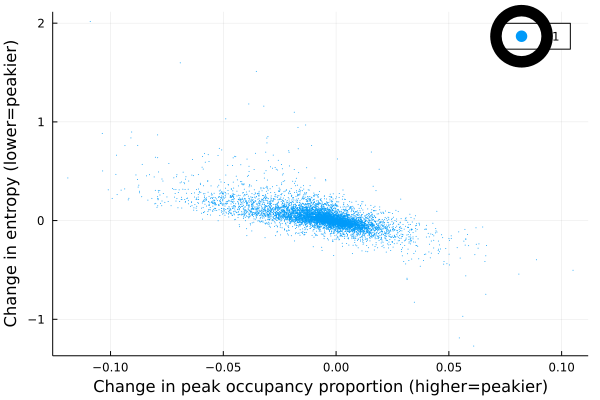

In [76]:
sensor_change.peak_entr_ch = sensor_change.postpandemic_entropy .- sensor_change.prepandemic_entropy
sensor_change.peak_occ_ch = sensor_change.postpandemic_occ - sensor_change.prepandemic_occ
scatter(sensor_change.peak_occ_ch, sensor_change.peak_entr_ch, markersize=0.1, alph=0.5)
xlabel!("Change in peak occupancy proportion (higher=peakier)")
ylabel!("Change in entropy (lower=peakier)")

In [98]:
# entropy indicates peakier, kfac indicates less peaky
sensor_change[coalesce.(sensor_change.peak_entr_ch .< -0.5std(skipmissing(sensor_change.peak_entr_ch)), false) .&&
    coalesce.(sensor_change.peak_occ_ch .< -0.5std(skipmissing(sensor_change.peak_occ_ch)), false), :station]

60-element Vector{Union{Missing, Int64}}:
    400067
    400270
    401351
    401892
    403425
    405673
    407157
    407865
    409480
    400108
    402560
 500011011
 500011022
         ⋮
   1210669
   1210688
   1210697
   1210706
   1210716
   1210745
   1211586
   1211787
   1212480
   1212484
   1221254
   1209542

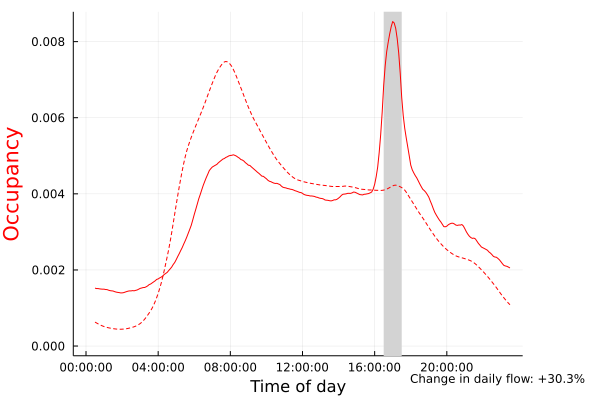

In [99]:
plotst(402560, flow=false, normalize=true)

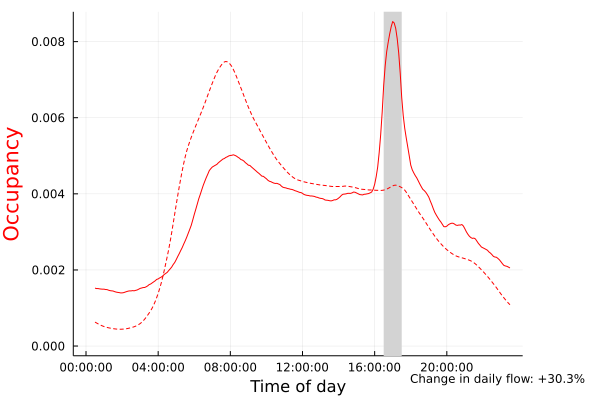

In [102]:
plotst(402560, flow=false, normalize=true)

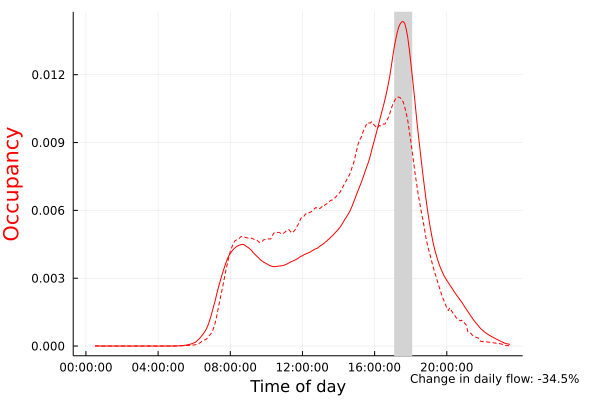

In [104]:
plotst(1210716, flow=false, normalize=true)

In [107]:
sensor_change[sensor_change.station .== 1210716, [:prepandemic_entropy, :postpandemic_entropy]]

,prepandemic_entropy,postpandemic_entropy
,Float64?,Float64?
1,7.25522,7.14585


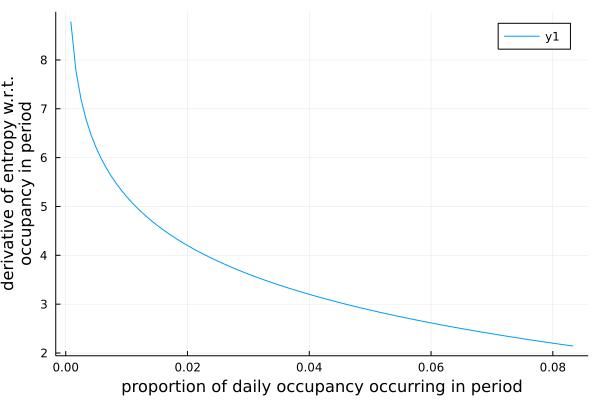

In [137]:
plot((1:100) ./ (24 * 5 * 10), .-(log.((1:100) ./ (24 * 5 * 10)) .+ 1) ./ log(2))
xlabel!("proportion of daily occupancy occurring in period")
ylabel!("derivative of entropy w.r.t.\noccupancy in period")

In [43]:
sensor_change[sensor_change.station .== 761644, [:prepandemic_occ, :postpandemic_occ, :prepandemic_entropy, :postpandemic_entropy]]

,prepandemic_occ,postpandemic_occ,prepandemic_entropy,postpandemic_entropy
,Float64?,Float64?,Float64?,Float64?
1,0.117389,0.0746068,7.92172,7.86034


In [108]:
names(meta)

14-element Vector{String}:
 "ID"
 "fwy_stable"
 "dir_stable"
 "lanes_stable"
 "max_shift_meters"
 "Latitude"
 "Longitude"
 "Fwy"
 "Dir"
 "District"
 "Lanes"
 "County"
 "geom"
 "urban"

In [126]:
fips = CSV.read("../data/all-geocodes-v2020.csv", DataFrame);
names(fips)

7-element Vector{String}:
 "Summary Level"
 "State Code (FIPS)"
 "County Code (FIPS)"
 "County Subdivision Code (FIPS)"
 "Place Code (FIPS)"
 "Consolidtated City Code (FIPS)"
 "Area Name (including legal/statistical area description)"

In [129]:
open("../fig/less_peaky_occ_and_more_peaky_entr.html", write=true) do out
    write(out, """
        <!DOCTYPE html>
        <html>
        <head>
        <title>Less peaky occupancy, more peaky entropy (>0.25 std dev)</title>
        <style type="text/css">
        body { font-family: "Open Sans", sans-serif }
        </style>
        </head>
        <body>
        <h1>Less peaky occupancy, more peaky entropy</h1>
        """)
    
    candidates = sensor_change[coalesce.(sensor_change.peak_entr_ch .< -0.25std(skipmissing(sensor_change.peak_entr_ch)), false) .&&
        coalesce.(sensor_change.peak_occ_ch .< -0.25std(skipmissing(sensor_change.peak_occ_ch)), false), :]
    
    write(out, "$(nrow(candidates)) total")

    for row in Tables.rows(candidates)
        stmeta = meta[meta.ID .== row.station, :][1,:]
        
        url = "https://www.openstreetmap.org/search?query=$(stmeta.Longitude)%2C$(stmeta.Latitude)#map=15/$(stmeta.Longitude)/$(stmeta.Latitude)"
        
        write(out, "<h2 id=\"$(row.station)\">Sensor $(row.station)</h2>")
        cty = fips[fips[!, "State Code (FIPS)"] .== 6 .&& fips[!, "County Code (FIPS)"] .== stmeta.County, "Area Name (including legal/statistical area description)"][1]
        write(out, "<a href=\"$(url)\">Highway $(stmeta.Fwy) $(stmeta.Dir) in $(cty)</a><br/>")
        
        plt = plotst(row.station, normalize=true, flow=false)
        # hopefully this becomes an svg
        show(out, MIME("text/html"), plt)
        
        write(out, "<br/>Entropy: pre (solid): $(round(row.prepandemic_entropy, digits=2)), post (dashed): $(round(row.postpandemic_entropy, digits=2))<br/>")
        write(out, "occ k-factor: pre (solid): $(round(row.prepandemic_occ, digits=2)), post (dashed): $(round(row.postpandemic_occ, digits=2))")
    end
    
    write(out, "</body></html>")
end
            
        

14

In [131]:
open("../fig/more_peaky_occ_and_less_peaky_entr.html", write=true) do out
    write(out, """
        <!DOCTYPE html>
        <html>
        <head>
        <title>Less peaky occupancy, more peaky entropy (>0.25 std dev)</title>
        <style type="text/css">
        body { font-family: "Open Sans", sans-serif }
        </style>
        </head>
        <body>
        <h1>More peaky occupancy, less peaky entropy</h1>
        """)
    
    candidates = sensor_change[coalesce.(sensor_change.peak_entr_ch .> 0.25std(skipmissing(sensor_change.peak_entr_ch)), false) .&&
        coalesce.(sensor_change.peak_occ_ch .> 0.25std(skipmissing(sensor_change.peak_occ_ch)), false), :]
    
    write(out, "$(nrow(candidates)) total")

    for row in Tables.rows(candidates)
        stmeta = meta[meta.ID .== row.station, :][1,:]
        
        url = "https://www.openstreetmap.org/search?query=$(stmeta.Longitude)%2C$(stmeta.Latitude)#map=15/$(stmeta.Longitude)/$(stmeta.Latitude)"
        
        write(out, "<h2 id=\"$(row.station)\">Sensor $(row.station)</h2>")
        cty = fips[fips[!, "State Code (FIPS)"] .== 6 .&& fips[!, "County Code (FIPS)"] .== stmeta.County, "Area Name (including legal/statistical area description)"][1]
        write(out, "<a href=\"$(url)\">Highway $(stmeta.Fwy) $(stmeta.Dir) in $(cty)</a><br/>")
        
        plt = plotst(row.station, normalize=true, flow=false)
        # hopefully this becomes an svg
        show(out, MIME("text/html"), plt)
        
        write(out, "<br/>Entropy: pre (solid): $(round(row.prepandemic_entropy, digits=2)), post (dashed): $(round(row.postpandemic_entropy, digits=2))<br/>")
        write(out, "occ k-factor: pre (solid): $(round(row.prepandemic_occ, digits=2)), post (dashed): $(round(row.postpandemic_occ, digits=2))")
    end
    
    write(out, "</body></html>")
end
            
        

14

## Conditioning on the DV when evaluating changes at stations that increased/decreased in total flow

In some ways we're conditioning on the DV. We've observed that occupancy is less peaky, and flow is the same. There are several ways this could happen:

1. Demand is less peaked. This would cause occupancy to be less peaked. Depending on the congestion regime during the peak before, flow might be less peaked (if previously uncongested, flow tracks with occ), more peaked (if flow was suppressed by gridlock before), or about the same (combination of both effects).
2. Flow is lower, and peak was previously congested, though demand has not changed. This would cause occupancy to be less peaked, flow could be peakier if suppressed.

In [177]:
# first, find the sensors
sensor_change.occ_peak_inc = coalesce.(sensor_change.postpandemic_occ .- sensor_change.prepandemic_occ .> 0.01, false)
sensor_change.occ_peak_dec = coalesce.(sensor_change.postpandemic_occ .- sensor_change.prepandemic_occ .< -0.01, false)
sensor_change.flow_peak_inc = coalesce.(sensor_change.postpandemic_flow .- sensor_change.prepandemic_flow .> 0.01, false)
sensor_change.flow_peak_dec = coalesce.(sensor_change.postpandemic_flow .- sensor_change.prepandemic_flow .< -0.01, false)
sensor_change.vol_change = sensor_change.postpandemic_tot_flow ./ sensor_change.prepandemic_tot_flow .- 1;

In [178]:
sensor_change[sensor_change.occ_peak_inc .&& sensor_change.flow_peak_inc .&& (abs.(sensor_change.vol_change) .< 0.02), :]

,station,prepandemic_occ,pandemic_occ,postpandemic_occ,prepandemic_flow,pandemic_flow
,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,500010122,0.181321,0.122994,0.207747,0.0627416,0.11285
2,500011012,0.0934642,0.109252,0.110173,0.089411,0.107318
3,717450,0.0769414,0.0877593,0.0876178,0.0349262,0.0473024
4,1221451,0.123499,0.110419,0.163542,0.05339,0.0710848


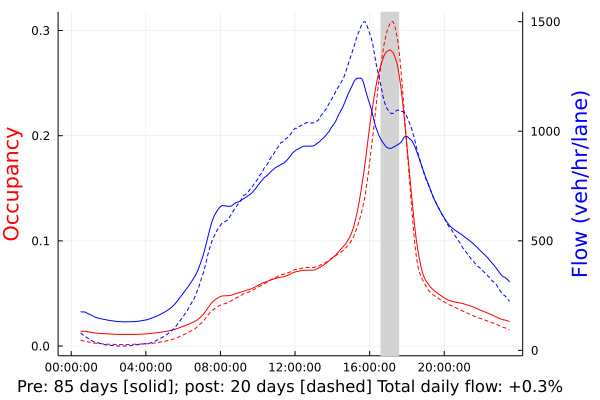

In [183]:
occ_inc_flow_inc = plotst(500010122)

In [189]:
sensor_change[sensor_change.occ_peak_inc .&& sensor_change.flow_peak_dec .&& (abs.(sensor_change.vol_change) .< 0.02), :]

,station,prepandemic_occ,pandemic_occ,postpandemic_occ,prepandemic_flow,pandemic_flow
,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,315927,0.111791,0.0689992,0.129754,0.0701127,0.0745865
2,400570,0.092118,0.120424,0.117662,0.0674321,0.0627228
3,415657,0.128205,0.126606,0.142174,0.0570442,0.0598534
4,602303,0.0893595,0.0869214,0.116728,0.064258,0.0652307
5,602368,0.0758321,0.0986217,0.115155,0.0712444,0.0739465
6,717995,0.089347,0.0796256,0.104257,0.0595916,0.0597064
7,764227,0.0955007,0.0697444,0.119209,0.0581719,0.056611
8,767791,0.0761188,0.0827625,0.110229,0.0791394,0.0818618
9,801552,0.090478,0.0689079,0.102768,0.0638904,0.0589336


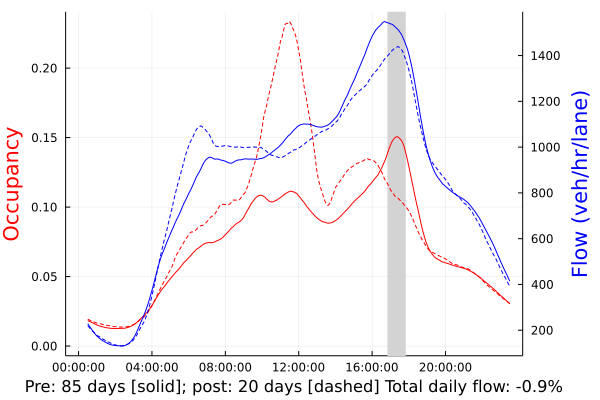

In [190]:
plotst(315927)

In [191]:
sensor_change[sensor_change.occ_peak_dec .&& sensor_change.flow_peak_inc .&& coalesce.(abs.(sensor_change.vol_change) .< 0.02, false), :]

,station,prepandemic_occ,pandemic_occ,postpandemic_occ,prepandemic_flow,pandemic_flow
,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,317789,0.0919805,0.0835781,0.0799058,0.072546,0.0880382
2,400604,0.125398,0.0774561,0.0799636,0.0543185,0.0721638
3,400683,0.136409,0.117313,0.111586,0.0734529,0.102639
4,401539,0.147835,0.128841,0.0886276,0.0473761,0.0755626
5,401692,0.144755,0.0788535,0.0899208,0.0576488,0.0750797
6,401875,0.117073,0.0749541,0.07351,0.0567671,0.080203
7,402794,0.139421,0.173927,0.116817,0.0459875,0.0582007
8,404907,0.125506,0.0978113,0.113272,0.0472278,0.0812241
9,404911,0.127378,0.111887,0.0961287,0.0497877,0.0786083


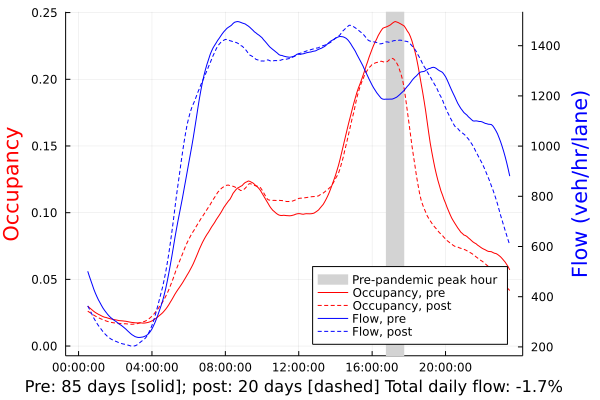

In [199]:
plotst(769389, legend=:bottomright)


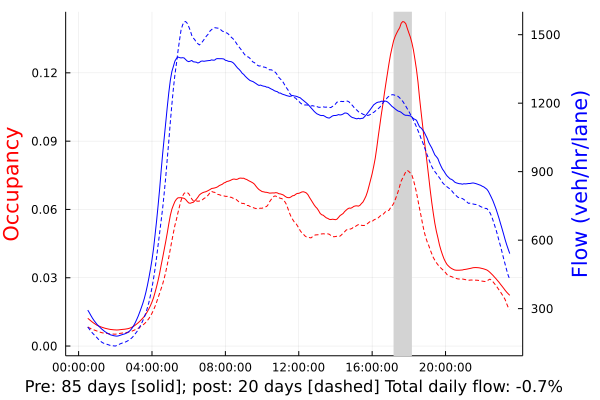

In [193]:
plotst(404911)

In [22]:
scatter(occflow.

16272576